Importing of all the necessary libraries

In [25]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision 
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

Uploading dataset and using transforms to convert into tensors

In [34]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_dataset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
test_dataset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Making trainset, valset and testset

In [35]:
train_size=int(0.8*len(train_dataset))
val_size=len(train_dataset)-train_size
trainset, valset = random_split(train_dataset, [train_size, val_size])

In [36]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Defining a basic CNN model for image classification 

In [37]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  
        self.fc2 = nn.Linear(512, 64) 
        self.fc3 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  
        x = self.pool(torch.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 8 * 8)  
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

Checking for cuda 

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)

Deploying loss criteria and optimizer

In [39]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Defining training function,validation test function and function to plot the accuracies

In [40]:
def train_model(epochs=7):
    train_losses = []
    val_losses = []
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()  
        running_loss = 0.0
        epoch_train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_train_loss += loss.item()

            if i % 100 == 99:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
                running_loss = 0.0

        avg_train_loss = epoch_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        val_loss, val_acc = validate_model()
        val_losses.append(val_loss)
        print(f'Epoch {epoch + 1}, Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_cnn_model.pth')
            print(f'Best model saved with accuracy: {best_val_acc:.2f}%') # Finding the best model according to val accuracy

    print('Training Finished.')
    plot_losses(train_losses, val_losses)

def validate_model():
    model.eval() 
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(valloader)
    val_acc = 100 * correct / total
    return avg_val_loss, val_acc

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Training the model

Epoch 1, Batch 100, Loss: 1.938
Epoch 1, Batch 200, Loss: 1.586
Epoch 1, Batch 300, Loss: 1.479
Epoch 1, Batch 400, Loss: 1.355
Epoch 1, Batch 500, Loss: 1.284
Epoch 1, Batch 600, Loss: 1.239
Epoch 1, Validation Loss: 1.188, Validation Accuracy: 57.31%
Best model saved with accuracy: 57.31%
Epoch 2, Batch 100, Loss: 1.128
Epoch 2, Batch 200, Loss: 1.110
Epoch 2, Batch 300, Loss: 1.035
Epoch 2, Batch 400, Loss: 1.010
Epoch 2, Batch 500, Loss: 1.000
Epoch 2, Batch 600, Loss: 0.997
Epoch 2, Validation Loss: 0.987, Validation Accuracy: 64.41%
Best model saved with accuracy: 64.41%
Epoch 3, Batch 100, Loss: 0.853
Epoch 3, Batch 200, Loss: 0.864
Epoch 3, Batch 300, Loss: 0.842
Epoch 3, Batch 400, Loss: 0.848
Epoch 3, Batch 500, Loss: 0.824
Epoch 3, Batch 600, Loss: 0.805
Epoch 3, Validation Loss: 0.886, Validation Accuracy: 68.97%
Best model saved with accuracy: 68.97%
Epoch 4, Batch 100, Loss: 0.677
Epoch 4, Batch 200, Loss: 0.701
Epoch 4, Batch 300, Loss: 0.716
Epoch 4, Batch 400, Loss: 0.

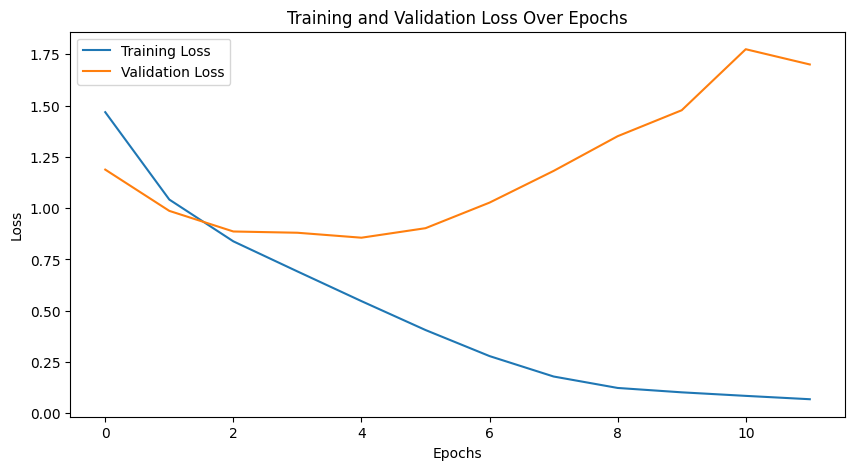

In [41]:
train_model(epochs=12)

Testing the model for final accuracy

In [42]:
def test_model():
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on test set: {100 * correct / total:.2f}%')

In [43]:
model.load_state_dict(torch.load('best_cnn_model.pth'))
test_model()

C:\Users\rishi\AppData\Local\Temp\ipykernel_18744\3979399372.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn_model.pth'))


Accuracy on test set: 72.28%


Hence the final accuracy obtained on the test dataset is 72.28% (I tried training using several different batch_sizes, learning rates, different types of layers in the model etc...all of them tend to have the same best validation accuracy. So the one shown in this notebook is one out of many trials I did)